# Post Deployment Data QA Desktop Search Instrumentation

Tasks:
* **A/B Test Setup for Search Changes** [T259250](https://phabricator.wikimedia.org/T259250)
* **SearchSatisfaction Changes** [T262300](https://phabricator.wikimedia.org/T262300)

QA Doc: https://docs.google.com/spreadsheets/d/1DpuXcpUdFPqsupiyeDpNH50NiISNWP1c3VwiEK9zqpw/edit#gid=0

## Overview

In [T256100](https://phabricator.wikimedia.org/T256100), we added a skin version field and new values for the inputLocation and extraParams fields to record data as part of the following two AB tests on deployed search changes: 
1) The first on the new location of the search widget.
2) The second on the new widget / experience we're currently building in Vue.js.

These two A/B tests together support four possible configurations:

|skinVersion|	inputLocation|	extraParams	|Description|
|:--------|:--------|:--------|:--------|
|legacy|	"header-navigation"|	|	Vector Legacy skin with Legacy search (current master)|
|latest|	"header-navigation"|	|	Vector Latest skin with Legacy search (current master)|
|latest|	"header-moved"|		|Vector Latest skin with Legacy search and latest location|
|latest|	"header-moved"|	"WVUI"|	Vector Latest skin with Latest search and latest location|


The new location of the search functionarily was deployed to all projects on 28 September 2020. The new location is available by default for anonymous users on our early adopter wikis, and by preference for all other users.

We are performing an A/B test of the new location with logged-in users on our early adopter wikis. 50% of logged-in users are seeing the new experience, while the other 50% are seeing the old experience. The test only applies to users on modern vector.


The [SearchSatisfaction Schema](https://meta.wikimedia.org/wiki/Schema:SearchSatisfaction) will be used to track events from these changes.

Note: Bucketing is done on a search session basis. 

I checked the following scenarios:
* Check events and distinct sessions per header location (PASSED)
* Check date when events started coming in and the number of events appear as expected (PASSED)
* Correct inputLocations associated with each skin version (header-moved should not be recorded with legacy) (PASSED: BUG FIX DEPLOYED ON OCTOBER 13)
* Check that skinVersion is only recorded when skin is vector (PASSED)
* Check associated actions and sources (PASSED)
* Check events appear for wikis as expected (PASSED)
* Check trend of logged in and logged out sessions and events. (PASSED) 
* Check that AB test is balanced (PASSED)

In [94]:
shhh <- function(expr) suppressPackageStartupMessages(suppressWarnings(suppressMessages(expr)))
shhh({
    library(tidyverse); library(glue); library(lubridate); library(scales)
})


## Collect Data

In [101]:
# collect data from SearchSatisfaction for the relevant fields.
query <- 
"SELECT
    event.inputLocation AS search_location,
    event.searchSessionId AS search_session,
    event.skinVersion AS vector_version,
    event.action AS action_type,
    event.source AS source_type,
    event.skin AS skin_type,
    wiki AS wiki,
    Count(*) AS events
FROM event.searchSatisfaction
-- review a few days prior to check when data started to come in
    WHERE year = 2020 and ((month = 09 and day >= 28) OR month >= 10) 
    -- remove bots
    AND useragent.is_bot = false 
GROUP BY 
    event.inputLocation,
    event.searchSessionId,
    event.skinVersion,
    event.action,
    event.source,
    event.skin,
    wiki"


In [102]:
search_sessions <-  wmfdata::query_hive(query)

Don't forget to authenticate with Kerberos using kinit



## Total number of events and sessions per header location across all Wikis

In [103]:
# overall
search_sessions_bylocation <-search_sessions %>%
# limit to search events completed in two new locations
    filter(search_location %in% c('header-moved', 'header-navigation'),
          filter) %>%
    group_by(search_location) %>%
    summarise(unique_sessions = n_distinct(search_session),
             total_events = sum(events)) 

search_sessions_bylocation

`summarise()` ungrouping output (override with `.groups` argument)



search_location,unique_sessions,total_events
<chr>,<int>,<int>
header-moved,35570589,256259728
header-navigation,38855815,276620657


Looking across all wikis, there should be a larger number of header-navigation search sessions and events as the new header location was only available by default for anonymous users on early adopter wikis and by preference for all ohter users. 

While the data show a slightly larger number of header-navigation events, I would expect this difference to be much higher. 

Update: Further investigation showed this was due to a bug that incorrectly logged header-navigation events as header-moved events on legacy skin. See further breakdowns below.

## Search Location by Vector Version and Skin Type on All Wikis

In [104]:
search_location_check <- search_sessions %>%
    filter(search_location %in% c('header-navigation', 'header-moved')) %>%
    group_by(search_location, vector_version, skin_type) %>%
    summarise(num_events = sum(events),
             num_sessions = n_distinct(search_session))
search_location_check

`summarise()` regrouping output by 'search_location', 'vector_version' (override with `.groups` argument)



search_location,vector_version,skin_type,num_events,num_sessions
<chr>,<chr>,<chr>,<int>,<int>
header-moved,latest,vector,30677585,3823712
header-moved,legacy,vector,225579407,31746694
header-moved,NULL,NULL,2736,492
header-navigation,latest,vector,3992199,576515
header-navigation,legacy,vector,272625862,38278963
header-navigation,NULL,NULL,2596,499


FAILED:

ISSUE: Confirmed that the two header location types are only being recorded for the vector skin type; however, there are a large number header-moved events being recorded with legacy, which is not expected. There are also some header location events being recorded without an associated vector_version or skin.

I will further review by wiki and day below to confirm when these events started occuring.

### Further Investigate Legacy Events

In [105]:
## collect all search events with new header recorded on legacy by date.

query <- 
"SELECT
    CONCAT(year, '-', LPAD(month, 2, '0'), '-', LPAD(day, 2, '0')) as date,
    event.inputLocation AS search_location,
    event.skin as skin_type,
    event.skinVersion AS vector_version,
    event.searchSessionId AS search_session,
    wiki,
    Count(*) as events
FROM event.searchSatisfaction 
-- review a few days prior to check when data started to come in
    WHERE year = 2020 AND ((month = 09 and day >= 20) OR month >= 10) 
-- review autocomplete searches on legacy
    AND event.action = 'searchResultPage'
    AND event.source = 'autocomplete'
    AND event.skinVersion = 'legacy'
    AND event.skin = 'vector'
    AND useragent.is_bot = false 
GROUP BY 
    CONCAT(year, '-', LPAD(month, 2, '0'), '-', LPAD(day, 2, '0')),
    event.inputLocation,
    event.skin,
    event.skinVersion,
    event.searchSessionId,
    wiki"

In [106]:
search_sessions_legacy <-  wmfdata::query_hive(query)

Don't forget to authenticate with Kerberos using kinit



In [107]:
search_sessions_legacy$date <- as.Date(search_sessions_legacy$date, format = "%Y-%m-%d")

### Legacy Events with New Header Location By Date

In [108]:
legacy_sessions_withnewsearchloc <- search_sessions_legacy %>%
    filter(search_location == 'header-moved') %>%
    group_by(date, vector_version) %>%
    summarise(num_events = sum(events),
             num_sessions = n_distinct(search_session)) %>%
    arrange(date)

legacy_sessions_withnewsearchloc

`summarise()` regrouping output by 'date' (override with `.groups` argument)



date,vector_version,num_events,num_sessions
<date>,<chr>,<int>,<int>
2020-09-22,legacy,6,3
2020-09-23,legacy,39,8
2020-09-24,legacy,124,8
2020-09-25,legacy,10,3
2020-09-26,legacy,38,6
2020-09-27,legacy,59,6
2020-09-28,legacy,1077,246
2020-09-29,legacy,4001,843
2020-09-30,legacy,1820084,264887


`summarise()` regrouping output by 'date', 'search_location' (override with `.groups` argument)



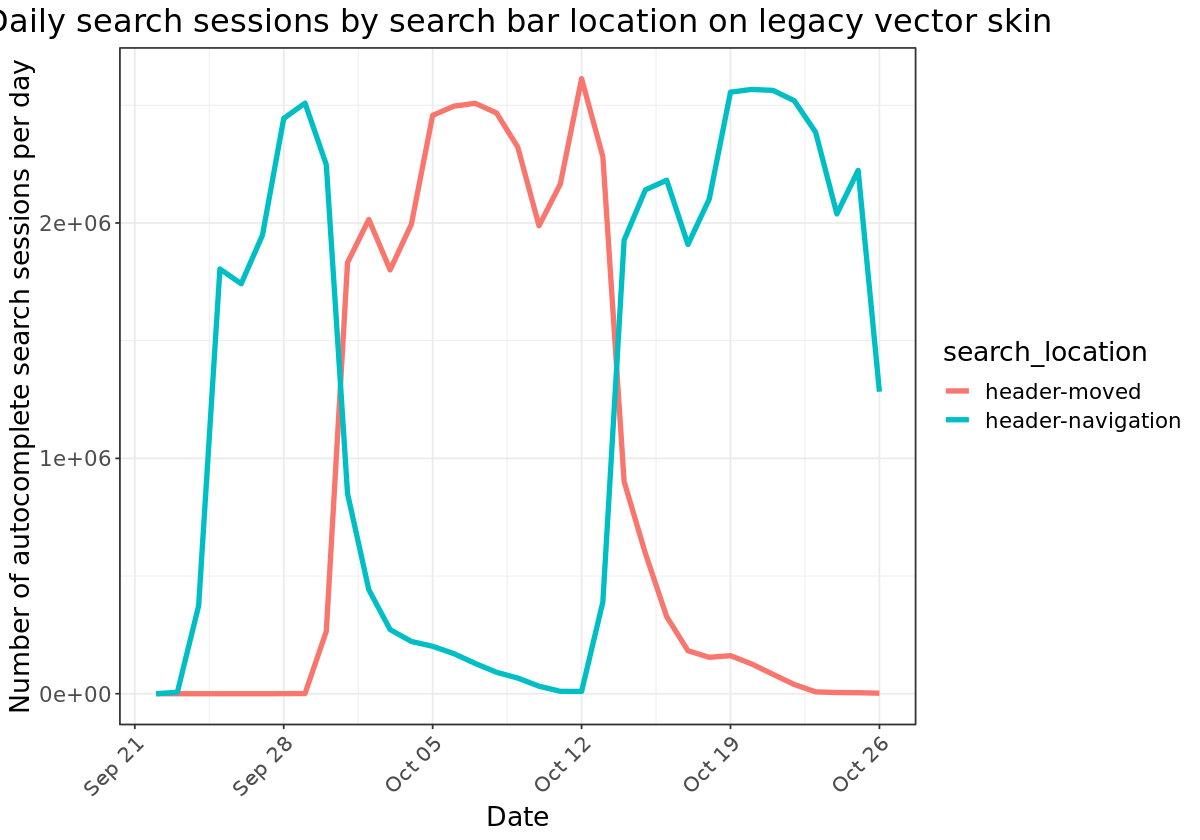

In [109]:
p <- search_sessions_legacy %>%
# compare header-moved to header-navigation dates
    filter(search_location %in% c('header-moved', 'header-navigation')) %>%
    group_by(date, search_location, vector_version) %>%
    summarise(num_events = sum(events),
             num_sessions = n_distinct(search_session)) %>%
    ggplot(aes(x=date, y= num_sessions, color = search_location)) +
    geom_line(size = 1.5) +
    scale_y_continuous() +
    labs (y = "Number of autocomplete search sessions per day",
          x = "Date",
         title = "Daily search sessions by search bar location on legacy vector skin")  +
     theme_bw() +
   theme(
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=16),
        axis.text.x = element_text(angle=45, hjust=1)) 
 
p

In [118]:
ggsave("Figures/daily_legacy_search_events.png", p, width = 16, height = 8, units = "in", dpi = 300)

Header-moved events on legacy start recording around September 28th, the date of deployment. Unlike the latest skin, they appear to drop on Oct 14th and have continued to decrease since then.

Upon further investigation, it was determined that bug leading to new header location events being recorded on legacy was due to a bug in the intrusmentation that was fixed on October 13th. Since the fix, these events are still declining.

### Further Investigate NULL events

In [111]:
## collect all search header events that do not have an associated vector skin
# Check number of events for each to see if roughly even or number of sessions?
query <- 
"SELECT
    CONCAT(year, '-', LPAD(month, 2, '0'), '-', LPAD(day, 2, '0')) as date,
    event.inputLocation AS search_location,
    event.skinVersion as vector_version,
    event.searchSessionId AS search_session,
    wiki,
    Count(*) as events
FROM event.searchSatisfaction 
-- review a few days prior to check when data started to come in
    WHERE year = 2020 AND ((month = 09 and day >= 20) OR month >= 10) 
-- further investigate instance where no skin was recorded
    AND event.skinVersion is NULL
    AND event.skin IS NULL
    AND event.action = 'searchResultPage'
    AND useragent.is_bot = false 
    AND event.source = 'autocomplete' 
GROUP BY 
    CONCAT(year, '-', LPAD(month, 2, '0'), '-', LPAD(day, 2, '0')),
    event.inputLocation,
    event.skinVersion,
    event.searchSessionId,
    wiki"

In [112]:
search_sessions_null <-  wmfdata::query_hive(query)

Don't forget to authenticate with Kerberos using kinit



In [113]:
search_sessions_null$date <- as.Date(search_sessions_null$date, format = "%Y-%m-%d")

In [114]:
daily_search_sessions_null_events <-search_sessions_null %>%
    filter(search_location %in% c('header-navigation', 'header-moved')) %>%
    group_by(search_location, vector_version, date) %>%
    summarise(num_sessions = n_distinct(search_session),
             num_events = sum(events))  %>%
    arrange(date)

daily_search_sessions_null_events

`summarise()` regrouping output by 'search_location', 'vector_version' (override with `.groups` argument)



search_location,vector_version,date,num_sessions,num_events
<chr>,<chr>,<date>,<int>,<int>
header-navigation,NULL,2020-09-23,1,1
header-navigation,NULL,2020-09-24,23,107
header-navigation,NULL,2020-09-25,119,630
header-navigation,NULL,2020-09-26,123,704
header-navigation,NULL,2020-09-27,104,574
header-navigation,NULL,2020-09-28,120,624
header-navigation,NULL,2020-09-29,90,453
header-moved,NULL,2020-09-30,5,30
header-navigation,NULL,2020-09-30,70,352


`summarise()` regrouping output by 'date' (override with `.groups` argument)



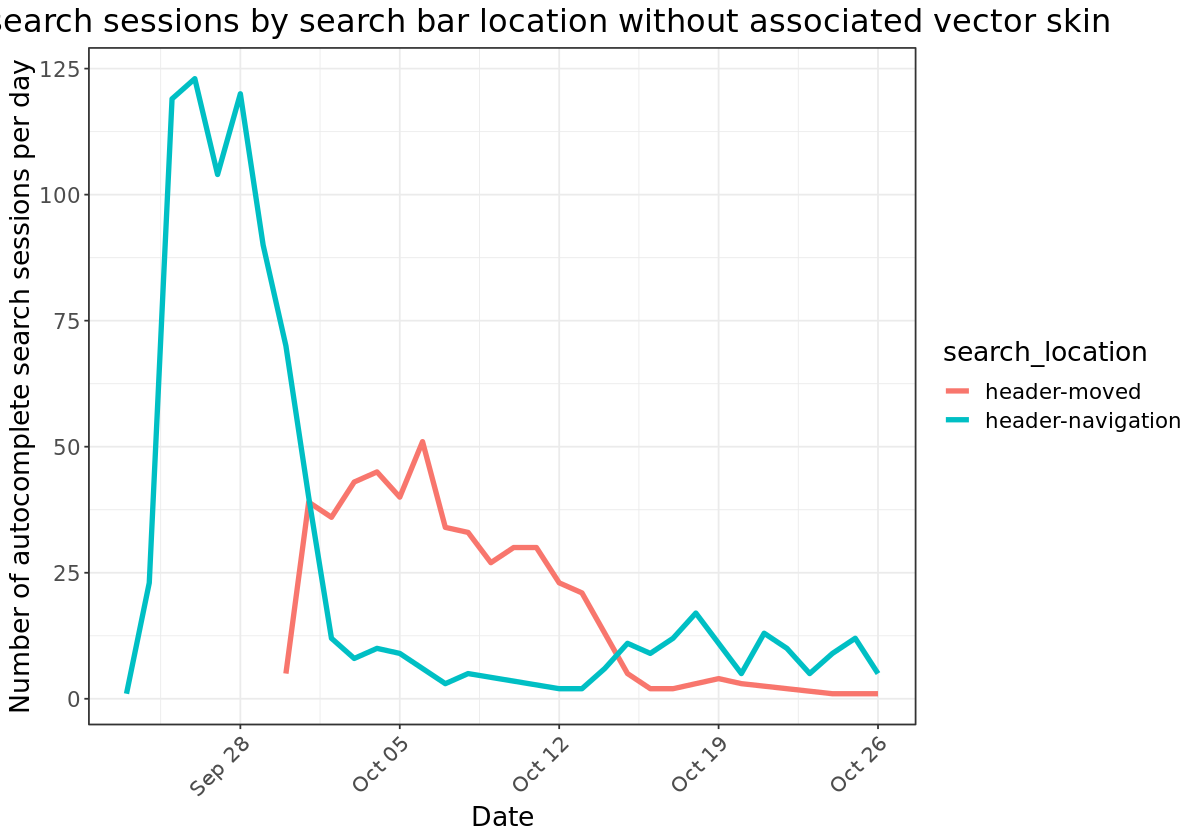

In [115]:
# plot null sessions
options(repr.plot.width = 10, repr.plot.height = 7)
p <- search_sessions_null %>%
# remove content - advanced search page searches
    filter(search_location %in% c('header-navigation', 'header-moved'))  %>%
    #filter(search_location != 'content') %>%
    group_by(date, search_location) %>%
    summarise(num_events = sum(events),
             num_sessions = n_distinct(search_session)) %>%
    ggplot(aes(x=date, y= num_sessions, color = search_location)) +
    geom_line(size = 1.5) +
    scale_y_continuous() +
    labs (y = "Number of autocomplete search sessions per day",
          x = "Date",
         title = "Daily search sessions by search bar location without associated vector skin")  +
     theme_bw() +
   theme(
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=16),
        axis.text.x = element_text(angle=45, hjust=1)) 
 
p

In [145]:
ggsave("Figures/daily_null_search_events.png", p, width = 16, height = 8, units = "in", dpi = 300)

Search events and sessions recorded as having a NULL vector skin version have been decreasing since deployment. Based on the trend lines show in chart below it looks like these NULL values are related to caching issues as the new instrumentation was deployed.  

We're currently only recording less than 12 NULL sessions per day on each wiki and they seem to be decreasing still so I don't think this is an issue. 

## Search Location Events on Latest Skin by Date

In [116]:
## collect all latest search header events by location and date
query <- 
"SELECT
    CONCAT(year, '-', LPAD(month, 2, '0'), '-', LPAD(day, 2, '0')) as date,
    event.inputLocation AS search_location,
    event.searchSessionId AS search_session,
    wiki,
    Count(*) as events
FROM event.searchSatisfaction 
-- review a few days prior to check when data started to come in
    WHERE year = 2020 AND ((month = 09 and day >= 20) OR month >= 10) 
-- only deployed on modern skin vector
    AND event.skinVersion = 'latest'
    AND event.skin = 'vector'
    AND useragent.is_bot = false 
    AND event.action = 'searchResultPage'
    AND event.source = 'autocomplete' 
GROUP BY 
    CONCAT(year, '-', LPAD(month, 2, '0'), '-', LPAD(day, 2, '0')),
    event.inputLocation,
    event.searchSessionId,
    wiki"

In [117]:
search_sessions_daily <-  wmfdata::query_hive(query)

Don't forget to authenticate with Kerberos using kinit



In [118]:
search_sessions_daily$date <- as.Date(search_sessions_daily$date, format = "%Y-%m-%d")

In [126]:
daily_search_sessions <-search_sessions_daily %>%
#remove content- advanced page events
    filter(search_location != 'content'
# review events after bug fix to address header-moved events on legacy
          )  %>%
    group_by(search_location, date) %>%
    summarise(unique_sessions = n_distinct(search_session),
             total_events = sum(events))  %>%
    arrange(date)
daily_search_sessions

`summarise()` regrouping output by 'search_location' (override with `.groups` argument)



search_location,date,unique_sessions,total_events
<chr>,<date>,<int>,<int>
header,2020-09-20,118534,922751
header,2020-09-21,143362,1092926
header,2020-09-22,140899,1054336
header,2020-09-23,141795,1078461
header-navigation,2020-09-23,392,2904
header,2020-09-24,120545,926857
header-navigation,2020-09-24,22423,144811
header,2020-09-25,43904,278737
header-navigation,2020-09-25,96679,695054


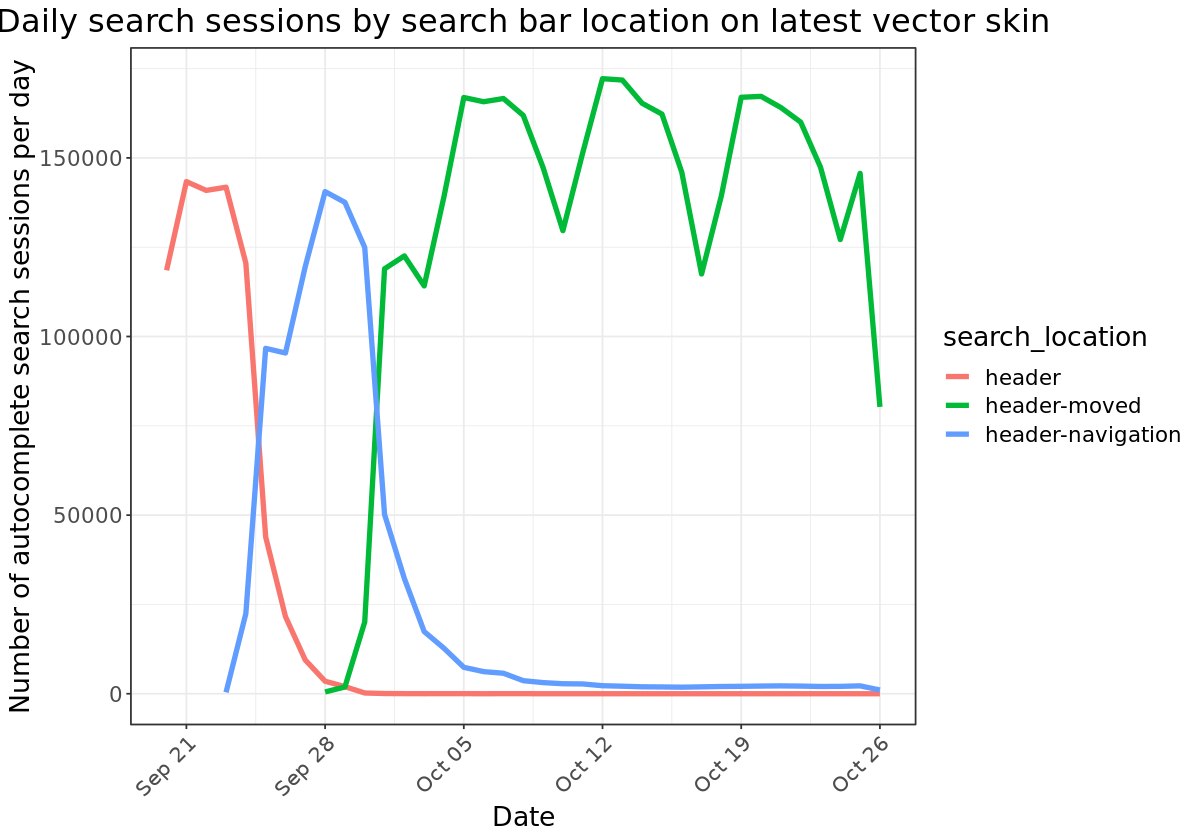

In [127]:
p <-daily_search_sessions %>%
    ggplot(aes(x=date, y= unique_sessions, color = search_location)) +
    geom_line(size = 1.5) +
    scale_y_continuous() +
    labs (y = "Number of autocomplete search sessions per day",
          x = "Date",
         title = "Daily search sessions by search bar location on latest vector skin")  +
     theme_bw() +
   theme(
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=16),
        axis.text.x = element_text(angle=45, hjust=1)) 
 
p

In [ ]:
ggsave("Figures/daily_latest_search_events.png", p, width = 16, height = 8, units = "in", dpi = 300)

The "header" location events are how the original search bar events were recorded prior to the instrumentation - these are events are dropping off as expected since it was replced by "header-navigation" events.

Header-moved(new search location) events start recording on the deployment date 28 September.  Following deployment, there is a signficant drop-off of header-navigation events on the latest vector skin. The decrease seems signficant but a decrease was expected since the new header was deployed as opt-out for all logged out users on early adopter wikis and 50% of logged in users.  An additional check of logged in vesus logged out users will help clarify.

## Review Search Location Events on All Skin Types By Action and Source Type

In [121]:
action_type_check <- search_sessions %>%
    filter(search_location %in% c('header-navigation', 'header-moved')) %>%
    group_by(search_location, action_type, source_type) %>%
    summarise(events = sum(events))

action_type_check

`summarise()` regrouping output by 'search_location', 'action_type' (override with `.groups` argument)



search_location,action_type,source_type,events
<chr>,<chr>,<chr>,<int>
header-moved,searchResultPage,autocomplete,256259728
header-navigation,searchResultPage,autocomplete,276620657


PASSED:

The header-moved and header-navigation events are only recorded with action=`SearchResultPage` and `source='autocomplete'` events as expected.

## Review Search Location Events by Wiki

In [129]:
test_wiki_counts <- search_sessions %>%
    filter(search_location %in% c('header-navigation', 'header-moved'),
    ## review test wikis where deployed
     wiki %in% c('euwiki', 'frwiki', 'hewiki', 'ptwikiversity', 'frwiktionary', 'fawiki')) %>%
    group_by(search_location, wiki) %>%
    summarise(events = sum(events),
             sessions = n_distinct(search_session))  %>%
    arrange(wiki)

test_wiki_counts 


`summarise()` regrouping output by 'search_location' (override with `.groups` argument)



search_location,wiki,events,sessions
<chr>,<chr>,<int>,<int>
header-moved,euwiki,325172,34312
header-navigation,euwiki,42852,5415
header-moved,fawiki,1199768,158652
header-navigation,fawiki,158559,24731
header-moved,frwiki,27472480,3317233
header-navigation,frwiki,3713332,526448
header-moved,frwiktionary,1480194,212714
header-navigation,frwiktionary,209442,37002
header-moved,hewiki,156401,92817


In [130]:
## Review non test wikis to see what the difference is

nontest_wiki_counts <- search_sessions %>%
    filter(search_location %in% c('header-navigation', 'header-moved'),
    ## review some non-test wikis where deployed
     wiki %in% c('enwiki', 'eswiki', 'ruwiki', 'zhwiki', 'dewiki')) %>%
    group_by(search_location, wiki) %>%
    summarise(events = sum(events),
             sessions = n_distinct(search_session))  %>%
    arrange(wiki)

nontest_wiki_counts 

`summarise()` regrouping output by 'search_location' (override with `.groups` argument)



search_location,wiki,events,sessions
<chr>,<chr>,<int>,<int>
header-moved,dewiki,28332468,3958386
header-navigation,dewiki,31971809,4523118
header-moved,enwiki,132251938,18201935
header-navigation,enwiki,163202407,22462494
header-moved,eswiki,12229252,1613443
header-navigation,eswiki,13987626,1815518
header-moved,ruwiki,11748048,1789305
header-navigation,ruwiki,13711217,2070640
header-moved,zhwiki,693042,301380


PASSED

On test wikis, there are 4 to 5% more header-moved events than header-navigation events across both skin types. This difference is expected as on the test wikis the new header was also show as default 50% of all logged-in users and by default to all anonymous users. 

On a sample of non-partner wikis, there are more header-navigation events and sessions compared to header-moved events. This is also expected as the new location is available as preference on these non-partner wikis. Note: This difference should be even higher but there was an issue in pre 13 October 2020 data of incorrectly logging header-moved events on legacy skin.



## Search Sessions by Logged in and Logged out Users

The isAnon field was added on 20 October 2020 to distinguish logged in and logged out users. I'll review events since deployment to confirm they are being recorded as expected.


In [131]:
## collect all search header events by location
# Check number of events for each to see if roughly even or number of sessions?
query <- 
"SELECT
    CONCAT(year, '-', LPAD(month, 2, '0'), '-', LPAD(day, 2, '0')) as date,
    event.skinVersion AS vector_version,
    event.skin AS skin_type,
    event.inputLocation AS search_location,
    event.isAnon AS is_anonymous,
    event.searchSessionId AS search_session,
    wiki,
    Count(*) as events
FROM event.searchSatisfaction 
-- review a few days prior to check when data started to come in
    WHERE year = 2020 AND ((month = 10 and day >= 18)) 
-- review autocomlete actions
    AND event.action = 'searchResultPage'
    AND event.source = 'autocomplete'
-- remove bots
    -- remove bots
    AND useragent.is_bot = false 
GROUP BY 
    CONCAT(year, '-', LPAD(month, 2, '0'), '-', LPAD(day, 2, '0')),
    event.skinVersion,
    event.skin,
    event.inputLocation,
    event.isAnon,
    event.searchSessionId,
    wiki"

In [132]:
search_sessions_byanon <-  wmfdata::query_hive(query)

Don't forget to authenticate with Kerberos using kinit



In [134]:
search_sessions_byanon$date <- as.Date(search_sessions_byanon$date, format = "%Y-%m-%d")

In [135]:
# rename is anon column to clarify logged in status

search_sessions_byanon_clean <- search_sessions_byanon %>%
 mutate(logged_in_status = case_when(
        is_anonymous == 'NULL' ~ "NULL",
        is_anonymous == 'false'~ "logged-in",
        is_anonymous == 'true' ~ "logged-out"))
 

### Confirm when logged in events start coming in

In [136]:
search_sessions_daily_byanon <- search_sessions_byanon_clean %>%
    filter(is_anonymous != 'NULL',
          skin_type == 'vector',
          vector_version == 'latest',
          search_location %in% c('header-moved', 'header-navigation'))  %>%
    group_by(date, search_location, logged_in_status) %>%
    summarise(num_events = sum(events),
              num_sessions = n_distinct(search_session)) %>%
    arrange(date)

head(search_sessions_daily_byanon, 10)

`summarise()` regrouping output by 'date', 'search_location' (override with `.groups` argument)



date,search_location,logged_in_status,num_events,num_sessions
<date>,<chr>,<chr>,<int>,<int>
2020-10-20,header-moved,logged-in,10488,1819
2020-10-20,header-moved,logged-out,842856,104794
2020-10-20,header-navigation,logged-in,7561,1383
2020-10-20,header-navigation,logged-out,6,2
2020-10-21,header-moved,logged-in,13966,2790
2020-10-21,header-moved,logged-out,1268413,160707
2020-10-21,header-navigation,logged-in,11430,2191
2020-10-21,header-navigation,logged-out,3,1
2020-10-22,header-moved,logged-in,13864,2693


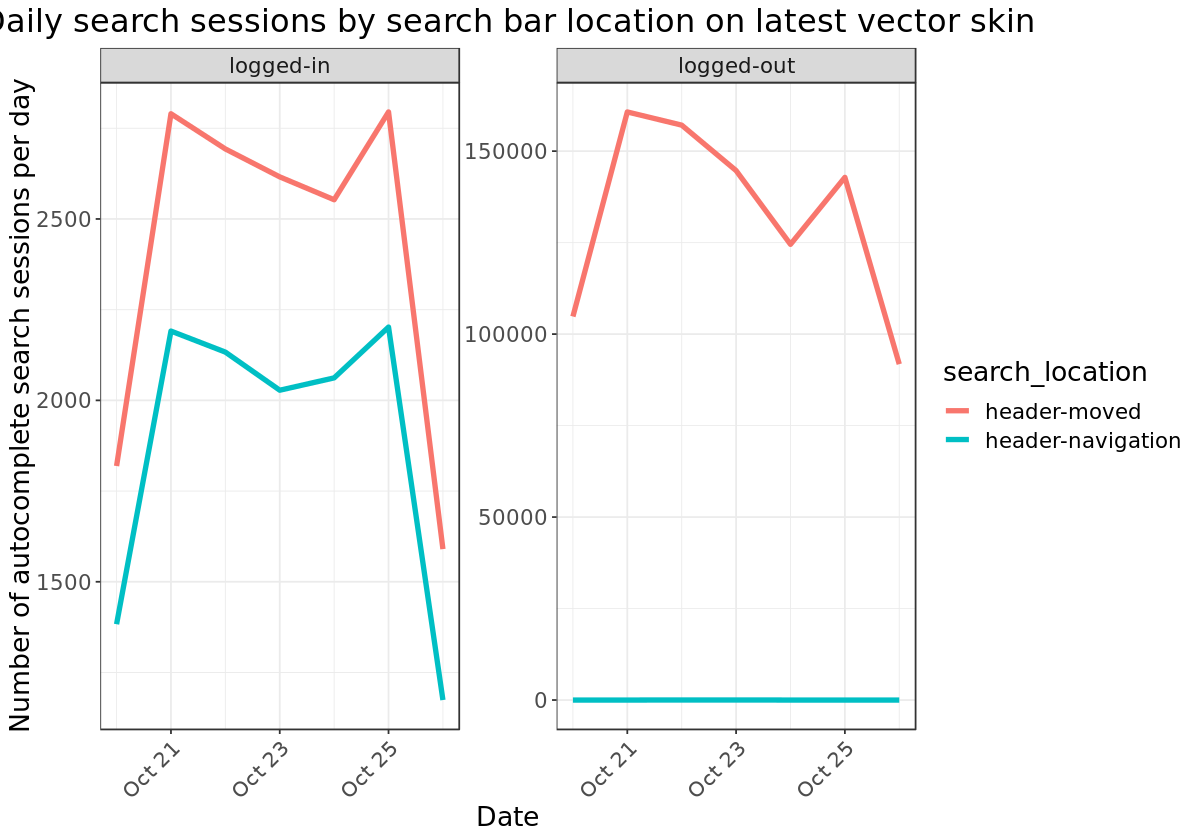

In [137]:
# Plot logged in and logged out events by search location
options(repr.plot.width = 10, repr.plot.height = 7)
p <-search_sessions_daily_byanon %>%
    ggplot(aes(x=date, y= num_sessions, color = search_location)) +
    geom_line(size = 1.5) +
    scale_y_continuous() +
    facet_wrap(~logged_in_status, scales = "free_y") +
    labs (y = "Number of autocomplete search sessions per day",
          x = "Date",
         title = "Daily search sessions by search bar location on latest vector skin")  +
     theme_bw() +
   theme(
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=16),
        axis.text.x = element_text(angle=45, hjust=1)) 
 
p

PASSED: Logged in events start appearing on 20 October, the date of deployment. 

The differences between search location sessions for logged out vs logged in users appears as expected. Most logged-out sessions on the latest vector skin are header-moved events, as the new location is available by default for anonymous users on our early adopter wikis.

The new search location was deployed to 50% of logged-in users on early adopter wikis and only preference by other, which is why there is a more event split of sessions for logged-in users. 

## Review total number of Search Location Events by Logged in Status

In [138]:
### Confirm number of events and sessions for two new search locations

search_sessions_bysearchlocation_byanon <- search_sessions_byanon_clean %>%
# Remove null events and only review vector skin events
    filter(is_anonymous != 'NULL',
              skin_type == 'vector',
          search_location %in% c('header-moved', 'header-navigation'))  %>%
    group_by(vector_version, search_location, logged_in_status ) %>%
    summarise(num_events = sum(events),
              num_sessions = n_distinct(search_session))


search_sessions_bysearchlocation_byanon 

`summarise()` regrouping output by 'vector_version', 'search_location' (override with `.groups` argument)



vector_version,search_location,logged_in_status,num_events,num_sessions
<chr>,<chr>,<chr>,<int>,<int>
latest,header-moved,logged-in,90586,16836
latest,header-moved,logged-out,7376053,925453
latest,header-navigation,logged-in,69639,13154
latest,header-navigation,logged-out,136,22
legacy,header-moved,logged-in,33,2
legacy,header-moved,logged-out,1048688,208045
legacy,header-navigation,logged-in,2697490,505192
legacy,header-navigation,logged-out,104985732,14152130


PASSED: Logged in status recorded for both vector versions (latest and legacy) and both search locations.

The numbers appears as expected. 
* There are very few header-navigation events events for logged-out users on latest vector, which makes sense as the new search location was deployed as opt out to these users.
* There are a few header-moved events on legacy recorded for both logged in and logged out users. These are likely due to caching issues/ old, long-running sessions. There are very few of these for logged in users compared to logged out.
* There are a 13% more search events on the legacy skin compared to the latest skin as the latest skin is available as a user preference on all wikis except for partner wikis.



## Review total number of search events by skin type and logged in status

In [139]:
search_sessions_byskintype_byanon <- search_sessions_byanon %>%
    filter(is_anonymous != 'NULL')  %>%
    group_by(skin_type, vector_version, is_anonymous ) %>%
    summarise(num_events = sum(events),
              num_sessions = n_distinct(search_session))


search_sessions_byskintype_byanon

`summarise()` regrouping output by 'skin_type', 'vector_version' (override with `.groups` argument)



skin_type,vector_version,is_anonymous,num_events,num_sessions
<chr>,<chr>,<chr>,<int>,<int>
cologneblue,NULL,false,1048,130
modern,NULL,false,27117,4949
modern,NULL,true,35,4
monobook,NULL,false,230259,42060
monobook,NULL,true,262,44
timeless,NULL,false,28029,5462
timeless,NULL,true,91,19
vector,latest,false,181311,30707
vector,latest,true,8293233,942578


PASSED: Confirmed that the isAnon field is being logged for multiple skin types. The number of events and sessions seem as expected.  

## Review total number of search events by wiki and logged in status

#### By Test Wiki

In [140]:
search_sessions_byskintype_byanon <- search_sessions_byanon_clean %>%
    filter(is_anonymous != 'NULL',
    wiki %in% c('euwiki', 'frwiki', 'hewiki', 'ptwikiversity', 'frwiktionary', 'fawiki')) %>%
    group_by(wiki, logged_in_status ) %>%
    summarise(num_events = sum(events),
              num_sessions = n_distinct(search_session))


search_sessions_byskintype_byanon

`summarise()` regrouping output by 'wiki' (override with `.groups` argument)



wiki,logged_in_status,num_events,num_sessions
<chr>,<chr>,<int>,<int>
euwiki,logged-in,3538,674
euwiki,logged-out,102687,8607
fawiki,logged-in,19891,3195
fawiki,logged-out,349904,38379
frwiki,logged-in,180096,31216
frwiki,logged-out,7320373,809328
frwiktionary,logged-in,14569,2229
frwiktionary,logged-out,396035,53823
hewiki,logged-in,8499,2339


PASSED

Sessions by logged in status appear as expected for all the wikis. There are 11 to 24% more logged out sessions compared to logged-in sessions on each partner wiki.

## Search Location Events for AB Test Users on Test Wikis

 We ran a check to confirm that it was deployed to 50% of users (using the modern vector skin) on each wiki as part of the AB test. Bucketing is done on a search session basis so we can review the number of distinct sessions.
 
During QA, we realized that there was no way to distinguish users in the AB test. An isAnon field was added to the schema on 20 October 2020. 

In [141]:
# Review AB events to confirm the buckets are balanced

query <- 
"SELECT
    CONCAT(year, '-', LPAD(month, 2, '0'), '-', LPAD(day, 2, '0')) as date,
    event.inputLocation AS search_location,
    event.isAnon AS is_anonymous,
    event.searchSessionId AS search_session,
    wiki,
    Count(*) as events
FROM event.searchSatisfaction 
-- ab test restarted on Oct 20th when isAnon field was added
    WHERE year = 2020 AND ((month = 10 and day >= 20)) 
-- review autocomplete actions
    AND event.action = 'searchResultPage'
    AND event.source = 'autocomplete'
    AND event.inputLocation IN ('header-moved', 'header-navigation')
-- review test wikis
    AND wiki IN ('euwiki', 'frwiki', 'hewiki', 'ptwikiversity', 'frwiktionary', 'fawiki')
-- deployed on on the new vector skin
    AND event.skinVersion = 'latest'
    AND event.skin = 'vector'
-- remove bots
    AND useragent.is_bot = false 
GROUP BY 
    CONCAT(year, '-', LPAD(month, 2, '0'), '-', LPAD(day, 2, '0')),
    event.inputLocation,
    event.isAnon,
    event.searchSessionId,
    wiki"

In [142]:
search_sessions_ab <-  wmfdata::query_hive(query)

Don't forget to authenticate with Kerberos using kinit



In [143]:
head(search_sessions_ab)

,date,search_location,is_anonymous,search_session,wiki,events
,<chr>,<chr>,<chr>,<chr>,<chr>,<int>
1,2020-10-20,header-moved,NULL,00ba5c6a8ef3b5fe18e0kghonubj,euwiki,1
2,2020-10-20,header-moved,NULL,0120bc4e7ffa52c550f3kghivbc4,frwiki,6
3,2020-10-20,header-moved,NULL,02f7da0483048d3708cdkghucc24,frwiktionary,9
4,2020-10-20,header-moved,NULL,044877287723d00825dckghnt2v6,hewiki,1
5,2020-10-20,header-moved,NULL,04749a73e9c8d4da8f54kghpfw3r,frwiki,8
6,2020-10-20,header-moved,NULL,070d1df7419f2b8dd0c2kghkyezr,fawiki,4


In [144]:
search_sessions_ab$date <- as.Date(search_sessions_ab$date, format = "%Y-%m-%d")

In [145]:
# rename is anon column to clarify logged in status

search_sessions_ab_clean <- search_sessions_ab %>%
 mutate(logged_in_status = case_when(
        is_anonymous == 'NULL' ~ "NULL",
        is_anonymous == 'false'~ "logged-in",
        is_anonymous == 'true' ~ "logged-out"))
 

In [146]:
search_sessions_ab_check <- search_sessions_ab_clean %>%
# review only logged in events on wikis
    filter(logged_in_status == 'logged-in') %>%
    group_by(search_location) %>%
    summarise(num_events = sum(events),
              num_sessions = n_distinct(search_session))

`summarise()` ungrouping output (override with `.groups` argument)



### Distinct Sessions for all users in AB test across wikis

In [147]:
search_sessions_ab_check

search_location,num_events,num_sessions
<chr>,<int>,<int>
header-moved,64572,11821
header-navigation,69623,13150


In [ ]:
### Distinct Sessions for all users in AB test Per Wiki

In [148]:
search_sessions_ab_check_bywiki <- search_sessions_ab_clean %>%
# review only logged in events on wikis
    filter(logged_in_status == 'logged-in') %>%
    group_by(search_location, wiki) %>%
    summarise(num_events = sum(events),
              num_sessions = n_distinct(search_session)) %>%
    arrange(wiki)

search_sessions_ab_check_bywiki

`summarise()` regrouping output by 'search_location' (override with `.groups` argument)



search_location,wiki,num_events,num_sessions
<chr>,<chr>,<int>,<int>
header-moved,euwiki,1825,355
header-navigation,euwiki,1276,273
header-moved,fawiki,6863,1075
header-navigation,fawiki,5486,974
header-moved,frwiki,49699,9136
header-navigation,frwiki,57845,10708
header-moved,frwiktionary,5187,787
header-navigation,frwiktionary,3985,656
header-moved,hewiki,990,464


The current difference is within the probable range of a random 50/50 split and the buckets look balanced. Note: There are very few header-moved and header-navigation events recorded for pwikiversity. As a result, it may be difficult to determine any impact of the header move on search sessions initiated during the AB test analysis. 